<a href="https://colab.research.google.com/github/felkira/unifact.github.io/blob/modeling/random_min_adam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Record Each Cell's Execution Time
!pip install keras-tcn
!pip install ipython-autotime
%load_ext autotime

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import json, re, string, gdown, math, time
from tcn import TCN
from keras.layers import Input, Embedding, Dense, Dropout, SpatialDropout1D, concatenate, GlobalAveragePooling1D, GlobalMaxPooling1D, Bidirectional
from keras.models import Model
from tensorflow.keras.preprocessing import text, sequence
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.math import confusion_matrix as cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report as cr, precision_recall_fscore_support as prfs
from collections import Counter
from random import randint
from google.colab import files

time: 4.04 s (started: 2022-12-11 16:43:06 +00:00)


In [ ]:
url = 'https://drive.google.com/u/0/uc?id=1p6hrwRZfgEOrHSQGPdMyZvdi3rQLHS2p&export=download'
gdown.download(url, 'valid-7hoaks.csv', quiet=False)

Downloading...
From: https://drive.google.com/u/0/uc?id=1p6hrwRZfgEOrHSQGPdMyZvdi3rQLHS2p&export=download
To: /content/valid-7hoaks.csv
100%|██████████| 2.07M/2.07M [00:00<00:00, 204MB/s]


'valid-7hoaks.csv'

time: 1.86 s (started: 2022-12-11 16:43:10 +00:00)


In [ ]:
main_data = pd.read_csv('/content/valid-7hoaks.csv')
pd.set_option('max_colwidth', 400)
main_data.head()

,kategori,judul,tanggal,narasi
0,Konten Yang Menyesatkan,buaya meter terbesar di dunia ditemukan di danau kota maine amerika serikat,26/11/2022,buaya meter terbesar dunia ditemukan danau kota maine amerika serikat
1,Konten Yang Salah,demo memprotes kecurangan hasil pemilihan umum di brazil pada november,25/11/2022,demo memprotes kecurangan hasil pemilihan umum brazil november
2,Konten Yang Menyesatkan,warga bogor meninggal hidup kembali,25/11/2022,warga bogor meninggal hidup
3,Konten Yang Menyesatkan,dari fauci akui vaksin tidak melindungi covid,25/11/2022,fauci akui vaksin melindungi covid
4,Konten Yang Menyesatkan,set top box dapat mendeteksi orang yang divaksin,25/11/2022,vaksin gratis set box punah gratis ternyata ternyata dalamnya rangkaian bluetooth low energy device membaca data orang orang yg divaksin aduh


time: 53.8 ms (started: 2022-12-11 16:43:12 +00:00)


In [ ]:
print("Shape of data (rows, cols)=>", main_data.shape)

Shape of data (rows, cols)=> (7530, 4)
time: 2.86 ms (started: 2022-12-11 16:43:12 +00:00)


In [ ]:
main_data.isnull().sum()

kategori    0
judul       0
tanggal     0
narasi      0
dtype: int64

time: 6.79 ms (started: 2022-12-11 16:43:12 +00:00)


In [ ]:
main_data.describe(include='all')

,kategori,judul,tanggal,narasi
count,7530,7530,7530,7530
unique,8,7530,1317,7528
top,Valid,buaya meter terbesar di dunia ditemukan di danau kota maine amerika serikat,17/10/2022,foto badai petir terlihat luar angkasa
freq,2350,1,87,2


time: 25.6 ms (started: 2022-12-11 16:43:12 +00:00)


In [ ]:
main_data.narasi.duplicated(keep="first").value_counts()

False    7528
True        2
Name: narasi, dtype: int64

time: 6.14 ms (started: 2022-12-11 16:43:12 +00:00)


In [ ]:
main_data.drop_duplicates(subset="narasi", keep="first", inplace=True)
main_data.reset_index(drop=True, inplace=True)
main_data.narasi.duplicated(keep="first").value_counts()

False    7528
Name: narasi, dtype: int64

time: 17.1 ms (started: 2022-12-11 16:43:12 +00:00)


In [ ]:
categories = main_data.kategori.unique()
print("Categories:\n", categories)

Categories:
 ['Konten Yang Menyesatkan' 'Konten Yang Salah' 'Satire/Parodi'
 'Konten Palsu' 'Konten Yang Dimanipulasi' 'Konten Tiruan'
 'Koneksi Yang Salah' 'Valid']
time: 1.48 ms (started: 2022-12-11 16:43:12 +00:00)


In [ ]:
main_data.kategori.value_counts()

Valid                       2349
Konten Yang Menyesatkan     1882
Konten Yang Salah           1313
Konten Palsu                 768
Konten Yang Dimanipulasi     643
Konten Tiruan                360
Satire/Parodi                125
Koneksi Yang Salah            88
Name: kategori, dtype: int64

time: 5.37 ms (started: 2022-12-11 16:43:12 +00:00)


In [ ]:
main_data.loc[main_data['kategori'] == 'Konten Yang Salah', 'kategori'] = 'Misleading Content/False Context/Manipulated Content'
main_data.loc[main_data['kategori'] == 'Konten Yang Menyesatkan', 'kategori'] = 'Misleading Content/False Context/Manipulated Content'
main_data.loc[main_data['kategori'] == 'Konten Yang Dimanipulasi', 'kategori'] = 'Misleading Content/False Context/Manipulated Content'

main_data.loc[main_data['kategori'] == 'Konten Palsu', 'kategori'] = 'Fabricated Content/Imposter Content'
main_data.loc[main_data['kategori'] == 'Konten Tiruan', 'kategori'] = 'Fabricated Content/Imposter Content'

main_data = main_data[main_data['kategori'] != 'Koneksi Yang Salah']
main_data = main_data[main_data['kategori'] != 'Satire/Parodi']

main_data.reset_index(drop=True, inplace=True)
main_data.kategori.value_counts()

Misleading Content/False Context/Manipulated Content    3838
Valid                                                   2349
Fabricated Content/Imposter Content                     1128
Name: kategori, dtype: int64

time: 17 ms (started: 2022-12-11 16:43:12 +00:00)


In [ ]:
XVal, YVal = list(main_data['narasi']), list(main_data['kategori'])

time: 1.38 ms (started: 2022-12-11 16:43:12 +00:00)


In [ ]:
data = main_data

time: 286 µs (started: 2022-12-11 16:43:12 +00:00)


In [ ]:
data['words'] = [len(x.split()) for x in data['narasi'].tolist()]

time: 12.6 ms (started: 2022-12-11 16:43:12 +00:00)


In [ ]:
data[['words','narasi']].head()

,words,narasi
0,10,buaya meter terbesar dunia ditemukan danau kota maine amerika serikat
1,8,demo memprotes kecurangan hasil pemilihan umum brazil november
2,4,warga bogor meninggal hidup
3,5,fauci akui vaksin melindungi covid
4,21,vaksin gratis set box punah gratis ternyata ternyata dalamnya rangkaian bluetooth low energy device membaca data orang orang yg divaksin aduh


time: 6.39 ms (started: 2022-12-11 16:43:12 +00:00)


In [ ]:
data['words'].describe()

count    7315.000000
mean       24.798770
std        34.406444
min         2.000000
25%        10.000000
50%        18.000000
75%        27.000000
max      1139.000000
Name: words, dtype: float64

time: 7.77 ms (started: 2022-12-11 16:43:12 +00:00)


In [ ]:
data.groupby(['kategori'])['words'].describe()

,count,mean,std,min,25%,50%,75%,max
kategori,,,,,,,,
Fabricated Content/Imposter Content,1128.0,34.176418,49.519877,3.0,9.0,17.5,41.0,951.0
Misleading Content/False Context/Manipulated Content,3838.0,22.686816,38.396630,2.0,8.0,11.0,22.0,1139.0
Valid,2349.0,23.746275,7.115402,8.0,20.0,23.0,27.0,121.0


time: 32.9 ms (started: 2022-12-11 16:43:12 +00:00)


In [ ]:
data = data[data['words']<=200]
data = data[data['words']>=3]
data.groupby(['kategori'])['words'].describe()

,count,mean,std,min,25%,50%,75%,max
kategori,,,,,,,,
Fabricated Content/Imposter Content,1118.0,31.190519,32.714856,3.0,9.0,17.0,40.75,196.0
Misleading Content/False Context/Manipulated Content,3812.0,20.960913,26.427491,3.0,8.0,11.0,22.00,196.0
Valid,2349.0,23.746275,7.115402,8.0,20.0,23.0,27.00,121.0


time: 24.1 ms (started: 2022-12-11 16:43:12 +00:00)


In [ ]:
data[data['kategori']=='Valid'] = data[data['kategori']=='Valid'][1000:2118]
data[data['kategori']=='Misleading Content/False Context/Manipulated Content'] = data[data['kategori']=='Misleading Content/False Context/Manipulated Content'][1000:2118]

data = data.dropna()
data.reset_index(drop=True, inplace=True)
data.groupby(['kategori'])['words'].describe()

,count,mean,std,min,25%,50%,75%,max
kategori,,,,,,,,
Fabricated Content/Imposter Content,1118.0,31.190519,32.714856,3.0,9.0,17.0,40.75,196.0
Misleading Content/False Context/Manipulated Content,1118.0,24.962433,30.107245,3.0,8.0,13.0,28.00,194.0
Valid,1118.0,24.450805,7.682183,11.0,20.0,23.0,27.00,121.0


time: 30.1 ms (started: 2022-12-11 16:43:12 +00:00)


In [ ]:
word_freq = data['narasi'].str.split(expand=True).stack().value_counts()
word_freq = word_freq.reset_index(name='freq').rename(columns={'index': 'word'})

time: 88.9 ms (started: 2022-12-11 16:43:12 +00:00)


In [ ]:
word_freq.head(10)

,word,freq
0,indonesia,686
1,orang,486
2,tahun,366
3,negara,319
4,covid,316
5,hari,296
6,jakarta,293
7,tersebut,290
8,yosua,290
9,video,256


time: 9.32 ms (started: 2022-12-11 16:43:12 +00:00)


In [ ]:
print("Number of distinct words in raw data: ", len(list(word_freq['word'])))

Number of distinct words in raw data:  13513
time: 1.74 ms (started: 2022-12-11 16:43:12 +00:00)


In [ ]:
# max_words = len(list(word_freq['word']))
max_words = len(list(word_freq[word_freq['freq']>=2]['word']))
max_len = int(data['words'].max())

print(max_words)
print(max_len)

7265
196
time: 4.12 ms (started: 2022-12-11 16:43:12 +00:00)


In [ ]:
data = data.sample(frac=1)

time: 1.87 ms (started: 2022-12-11 16:43:12 +00:00)


In [ ]:
X, Y = list(data['narasi']), list(data['kategori'])

encoder = LabelEncoder()
Y = to_categorical(encoder.fit_transform(Y), dtype='uint8')

print(Y.shape)
print(encoder.classes_)

(3354, 3)
['Fabricated Content/Imposter Content'
 'Misleading Content/False Context/Manipulated Content' 'Valid']
time: 6.41 ms (started: 2022-12-11 16:43:12 +00:00)


In [ ]:
print(np.argmax(Y, axis=1))

[2 2 0 ... 2 0 1]
time: 1.44 ms (started: 2022-12-11 16:43:13 +00:00)


In [ ]:
def define_report(prediction, test):
  y_pred_class = np.argmax(prediction, axis=1)
  y_class = np.argmax(test, axis=1)
  precision, recall, fscore, support = prfs(y_class, y_pred_class)
  report = cr(y_class, y_pred_class, target_names = encoder.classes_)
  return recall, report

def define_confusion(prediction, test):
  y_pred_class = np.argmax(prediction, axis=1)
  y_class = np.argmax(test, axis=1)
  con_mat = cm(labels=y_class, predictions=y_pred_class).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=3)
  con_mat_df = pd.DataFrame(con_mat_norm, index = encoder.classes_, columns = encoder.classes_)
  figure = plt.figure(figsize=(13, 10))
  sns.heatmap(con_mat_df, annot=True, fmt='.1%', cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

def define_plot(name, param):
  plt.figure(figsize=(15, 7))
  plt.title(name)
  plt.plot(param.history[name], label='train')
  plt.plot(param.history[f'val_{name}'], label='test')
  plt.legend()
  plt.show();

time: 3.99 ms (started: 2022-12-11 16:43:13 +00:00)


# **Embedding Random**

In [ ]:
def define_model(kernel_size, activation, optimizer, input_dim, max_length, output_dim = 300 ):
    
    inp = Input( shape=(max_length,))
    x = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=max_length)(inp)
    x = SpatialDropout1D(0.1)(x)
    
    x = Bidirectional(TCN(64, kernel_size=kernel_size, dilations = [1, 2], return_sequences=True, activation = activation, name = 'tcn1'))(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    conc = concatenate([avg_pool, max_pool])
    conc = Dropout(0.5)(conc)
    outp = Dense(Y.shape[1], activation="softmax")(conc)   

    model = Model(inputs=inp, outputs=outp)
    model.compile( loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

time: 1.61 ms (started: 2022-12-11 16:43:13 +00:00)


In [ ]:
model0_random = define_model(3, 'relu', 'adam', 300, 121)
model0_random.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 121)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 121, 300)     90000       ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 121, 300)    0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, 121, 128)     227968      ['spatial_dropout1d[0][0]']  

In [ ]:
callbacks = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=2, mode='min', restore_best_weights=True)

time: 952 µs (started: 2022-12-11 16:43:16 +00:00)


In [ ]:
trunc_type='post'
padding_type='post'
oov_tok = "<UNK>"
activations = ['tanh', 'relu', 'elu', 'selu', 'swish']
optimizers = ['adam']
kernel_sizes = [2, 3, 4, 5, 6, 7, 8]

columns = ['Optimizer', 'Activation', 'Filters', 'acc1', 'acc2', 'acc3', 'acc4', 'acc5', 'accAVG', 'loss1', 'loss2', 'loss3', 'loss4', 'loss5', 'lossAVG']
record = pd.DataFrame(columns = columns)
kfold = KFold(n_splits=5, shuffle=True)

sentences, labels = X, Y

clouds = []
valid_selected = []
false_selected = []
imposter_selected = []
models = []
recalls = []
reports = []
metas = []
exp = 0

for optimizer in optimizers:
  for activation in activations:
    for kernel_size in kernel_sizes:
      exp+=1
      print('--------------------------------------------------------------')
      print('Training {}: {} optimizer, {} activation, {} kernel size.'.format(exp, optimizer, activation, kernel_size))
      print('--------------------------------------------------------------')
      acc_list = []
      loss_list = []
      for train, test in kfold.split(sentences):

        train_x, test_x = [], []
        train_y, test_y = [], []
        
        for i in train:
          train_x.append(sentences[i])
          train_y.append(labels[i])
        for i in test:
          test_x.append(sentences[i])
          test_y.append(labels[i])

        train_valid = []
        train_false = []
        train_imposter = []
        for i in range(len(train_y)):
          label = list(encoder.inverse_transform([np.argmax(train_y[i])]))[0]
          if label == 'Valid':
            for j in train_x[i].split(): train_valid.append(j)
          if label == 'Misleading Content/False Context/Manipulated Content':
            for j in train_x[i].split(): train_false.append(j)
          if label == 'Fabricated Content/Imposter Content':
            for j in train_x[i].split(): train_imposter.append(j)
        
        valid_res = dict(Counter(train_valid))
        false_res = dict(Counter(train_false))
        imposter_res = dict(Counter(train_imposter))
        
        valid_selected.append({k: v for k, v in sorted(valid_res.items(), key=lambda item: item[1], reverse=True)})
        false_selected.append({k: v for k, v in sorted(false_res.items(), key=lambda item: item[1], reverse=True)})
        imposter_selected.append({k: v for k, v in sorted(imposter_res.items(), key=lambda item: item[1], reverse=True)})
        
        train_y = np.array(train_y)
        test_y = np.array(test_y)

        tokenizer = text.Tokenizer(num_words = max_words, oov_token=oov_tok)
        tokenizer.fit_on_texts(train_x)
        training_sequences = tokenizer.texts_to_sequences(train_x)
        test_sequences = tokenizer.texts_to_sequences(test_x)
        Xtrain = sequence.pad_sequences(training_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)
        Xtest = sequence.pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

        wordIdx = tokenizer.word_index
        clouds.append(wordIdx)
        vocabSize = len(wordIdx)+1

        model = define_model(kernel_size, activation, optimizer, input_dim=vocabSize, max_length=max_len)
        history = model.fit(Xtrain, train_y, batch_size=50, epochs=16, verbose=0, 
                  callbacks=[callbacks], validation_data=(Xtest, test_y))
        
        loss, acc = model.evaluate(Xtest, test_y, verbose=0)
        print(f'Loss: {loss} - Accuracy: {acc}\n')
        result = model.predict(Xtest)
        recall, report = define_report(result, test_y)
        metas.append([Xtest, test_y, result, history])
        reports.append(report)
        recalls.append(recall)
        acc_list.append(acc*100)
        loss_list.append(loss)
        models.append(model)
          
      mean_acc = np.array(acc_list).mean()
      mean_loss = np.array(loss_list).mean()
      parameters = [optimizer, activation, kernel_size]
      entries = parameters + acc_list + [mean_acc] + loss_list + [mean_loss]
      temp = pd.DataFrame([entries], columns=columns)
      record = record.append(temp, ignore_index=True)
      print('\n')

In [ ]:
record

,Optimizer,Activation,Filters,acc1,acc2,acc3,acc4,acc5,accAVG,loss1,loss2,loss3,loss4,loss5,lossAVG
0,adam,tanh,2,83.606559,84.202683,85.543966,83.755589,85.373133,84.496386,0.416513,0.400966,0.364084,0.396131,0.377854,0.391109
1,adam,tanh,3,82.712370,82.861400,83.904618,84.649777,82.835823,83.392798,0.416089,0.401230,0.357379,0.379468,0.423294,0.395492
2,adam,tanh,4,84.500748,85.394931,83.606559,85.991061,84.179103,84.734480,0.423591,0.391071,0.382486,0.333758,0.369106,0.380002
3,adam,tanh,5,84.798807,85.543966,83.904618,87.481374,83.880597,85.121872,0.372717,0.368615,0.411767,0.325854,0.386883,0.373167
4,adam,tanh,6,85.842025,82.265276,87.034279,83.904618,85.074627,84.824165,0.339775,0.422643,0.327624,0.388230,0.389671,0.373588
5,adam,tanh,7,86.587185,85.692996,84.351712,82.414305,85.522389,84.913718,0.359155,0.378476,0.381741,0.398374,0.353381,0.374226
6,adam,tanh,8,86.289120,88.077497,83.457524,84.053653,83.582091,85.091977,0.332520,0.335546,0.369418,0.396562,0.403906,0.367591
7,adam,relu,2,85.096872,81.818181,81.222057,82.712370,82.686567,82.707210,0.380357,0.480668,0.447317,0.405370,0.445824,0.431907
8,adam,relu,3,82.414305,84.202683,85.245901,82.265276,84.477609,83.721155,0.425810,0.411008,0.376765,0.418536,0.407108,0.407845
9,adam,relu,4,84.202683,84.500748,81.520116,81.967211,80.597013,82.557554,0.389137,0.370700,0.452231,0.418642,0.443001,0.414742


time: 23.7 ms (started: 2022-12-11 17:17:48 +00:00)


In [ ]:
record[['Activation', 'accAVG']].groupby(by='Activation').max().sort_values(by='accAVG', ascending=False)

,accAVG
Activation,
tanh,85.121872
elu,85.091798
relu,84.377116
swish,84.227506
selu,84.018329


time: 21 ms (started: 2022-12-11 17:17:48 +00:00)


In [ ]:
record[['Activation', 'lossAVG']].groupby(by='Activation').min().sort_values(by='lossAVG', ascending=True)

,lossAVG
Activation,
tanh,0.367591
elu,0.369800
selu,0.387732
relu,0.388805
swish,0.392001


time: 9.73 ms (started: 2022-12-11 17:17:48 +00:00)


In [ ]:
max_recall_0 = [i[0] for i in recalls]
max_recall_0_idx = [i for i in range(len(max_recall_0)) if max_recall_0[i] >= .8]
print(*max_recall_0_idx, sep=', ')

4, 7, 8, 13, 20, 21, 30, 46, 59, 62, 75, 81, 91, 94, 95, 97, 99, 106, 110, 123, 126, 128, 131, 134, 136, 137, 145
time: 8.01 ms (started: 2022-12-11 17:17:48 +00:00)


In [ ]:
recall_filtered = [m for m in [[i, rec[1]] for i, rec in enumerate(recalls) if i in max_recall_0_idx] if m[1] >= .8]

print(recall_filtered)

[[4, 0.8019323671497585], [8, 0.8090909090909091], [20, 0.8201754385964912], [30, 0.8051948051948052], [46, 0.8018018018018018], [62, 0.8609865470852018], [95, 0.8198198198198198], [106, 0.8080357142857143], [145, 0.8577981651376146]]
time: 3.29 ms (started: 2022-12-11 17:17:48 +00:00)


In [ ]:
for i in range(len(recall_filtered)):
  print(reports[recall_filtered[i][0]], '\n\n')

                                                      precision    recall  f1-score   support

                 Fabricated Content/Imposter Content       0.81      0.80      0.81       220
Misleading Content/False Context/Manipulated Content       0.78      0.80      0.79       207
                                               Valid       0.96      0.94      0.95       243

                                            accuracy                           0.85       670
                                           macro avg       0.85      0.85      0.85       670
                                        weighted avg       0.86      0.85      0.85       670
 


                                                      precision    recall  f1-score   support

                 Fabricated Content/Imposter Content       0.78      0.81      0.80       217
Misleading Content/False Context/Manipulated Content       0.77      0.81      0.79       220
                                               Valid 

In [ ]:
bests = [2, 5, 8]
selecteds = [recall_filtered[i][0] for i in bests]

time: 872 µs (started: 2022-12-11 17:20:10 +00:00)


In [ ]:
def tokenize(text, cloud):
  s = text.split()
  return [cloud[s[i]] if s[i] in cloud else 1 for i in range(len(s))]

def pad_sequence(seq):
  return [0 if i < (max_len - len(seq)) else seq[i - (max_len - len(seq))] for i in range(max_len)]

time: 1.45 ms (started: 2022-12-11 17:20:11 +00:00)


In [ ]:
results = []

for j in selecteds:
  predict_temp = []
  false_temp = []
  print(f'model-{j} predict')
  for i in range(len(XVal)):
    seq = tokenize(XVal[i], clouds[j])
    padded = np.array([pad_sequence(seq)])
    preds = models[j].predict(padded)
    proba = preds[0].tolist()
    classes = list(encoder.classes_)
    prediction = classes[proba.index(max(preds[0]))]
    if prediction == YVal[i]: predict_temp.append(True)
    else: false_temp.append(classes.index(YVal[i]))

  results.append(f'correct: {len(predict_temp)}/{len(XVal)}: {round(len(predict_temp)/len(XVal) * 100, 3)}%  -  false-i: {false_temp.count(0)}  -  false-m: {false_temp.count(1)}  -  false-v: {false_temp.count(2)}')

In [ ]:
for i in range(len(selecteds)):
  print('model:', selecteds[i], f'\n{results[i]}')

model: 20 
correct: 4628/7315: 63.267%  -  false-i: 43  -  false-m: 2377  -  false-v: 267
model: 62 
correct: 5992/7315: 81.914%  -  false-i: 380  -  false-m: 198  -  false-v: 745
model: 145 
correct: 6371/7315: 87.095%  -  false-i: 131  -  false-m: 582  -  false-v: 231
time: 1.15 ms (started: 2022-12-11 17:44:57 +00:00)


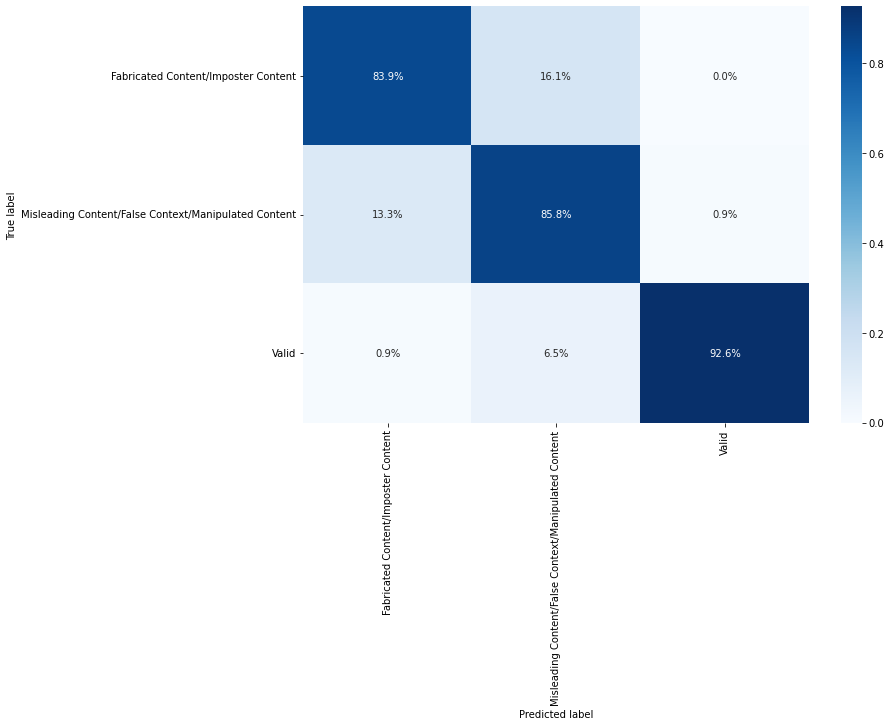

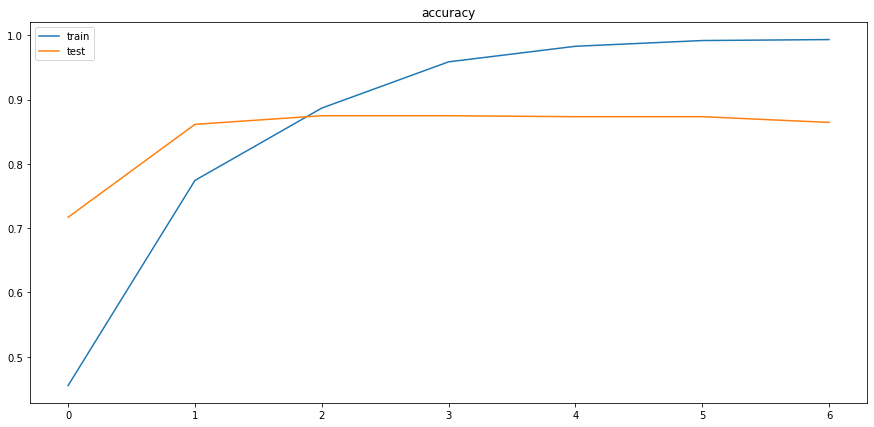

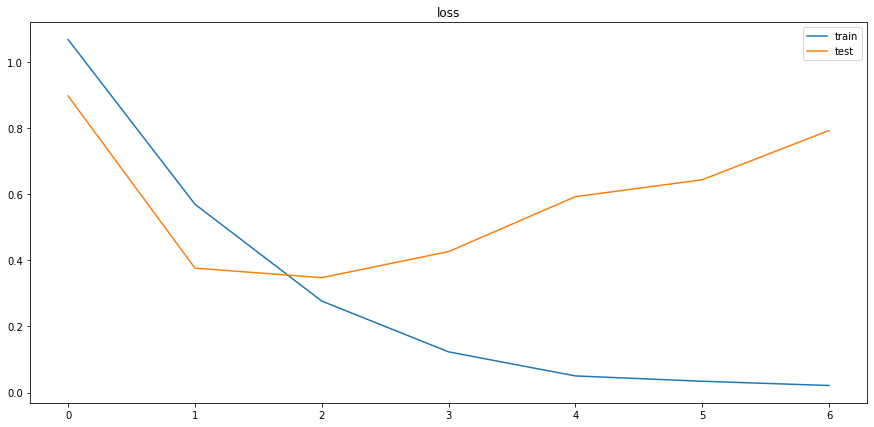




time: 1.52 s (started: 2022-12-11 17:54:05 +00:00)


In [ ]:
best = [145, 6371]
define_confusion(metas[best[0]][2], metas[best[0]][1])
print('\n')
define_plot('accuracy', metas[best[0]][3])
print('\n')
define_plot('loss', metas[best[0]][3])
print('\n\n')

In [ ]:
record.to_excel('acc_loss_records.xlsx', index=False, encoding='utf-8')

time: 529 ms (started: 2022-12-11 17:54:15 +00:00)


In [ ]:
def cr_to_excel(report, index, score):
    report_data = []
    lines = report.split('\n')
    for line in (lines[2:5]+lines[7:9]):
        row = {}
        row_data = line.split()
        row['class'] = ' '.join(row_data[0:-4])
        row['precision'] = row_data[-4]
        row['recall'] = row_data[-3]
        row['f1_score'] = row_data[-2]
        row['support'] = row_data[-1]
        row['accuracy'] = round(record.iloc[math.ceil((index+0.5)/5) - 1][f'acc{(index%5) + 1}'], 2)
        row['loss'] = round(record.iloc[math.ceil((index+0.5)/5) - 1][f'loss{(index%5) + 1}'], 4)
        row['activation'] = record.iloc[math.ceil((index+0.5)/5) - 1]['Activation']
        row['optimizer'] = record.iloc[math.ceil((index+0.5)/5) - 1]['Optimizer']
        row['kernel'] = record.iloc[math.ceil((index+0.5)/5) - 1]['Filters']
        row['test_score'] = round(((score-3354)/(7315-3354)*100), 2)
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_excel(f'classification_report-{index}.xlsx', index = False)

cr_to_excel(reports[best[0]], best[0], best[1])

time: 25 ms (started: 2022-12-11 17:54:43 +00:00)


In [ ]:
def clouds_to_json(index):
  with open(f'word_dict-{index}.json' , 'w') as file:    
    json.dump(clouds[index], file)

clouds_to_json(best[0])

time: 28.8 ms (started: 2022-12-11 17:55:13 +00:00)


In [ ]:
def res_to_json(index):
  with open(f'residu-{index}.json' , 'w') as file:    
    json.dump({'valid': valid_selected[index], 'false': false_selected[index], 'imposter': imposter_selected[index]}, file)

res_to_json(best[0])

time: 33.2 ms (started: 2022-12-11 17:55:17 +00:00)


In [ ]:
models[best[0]].save(f"model-{best[0]}.h5")

time: 236 ms (started: 2022-12-11 17:55:22 +00:00)


In [ ]:
files.download('acc_loss_records.xlsx')

files.download(f'classification_report-{best[0]}.xlsx')
files.download(f'word_dict-{best[0]}.json')
files.download(f'residu-{best[0]}.json')
files.download(f'model-{best[0]}.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 26.3 ms (started: 2022-12-11 17:55:26 +00:00)
